# Parallel Programming in R
With an increasing amount of data and more complex algorithms available to scientists and practitioners today, parallel processing is almost always a must, and in fact, is expected in packages implementing time-consuming methods. This course introduces you to concepts and tools available in R for parallel computing and provides solutions to a few important non-trivial issues in parallel processing like reproducibility, generating random numbers and load balancing.

## Can I Run My Application in Parallel?

In order to take advantage of parallel environment, the application needs to be split into pieces. In this introductory chapter, you will learn about different ways of partitioning and how it fits different hardware configurations. You will also be introduced to various R packages that support parallel programming.

### Find the most frequent words in a text
We will now turn to partitioning by data. Here is an example that will be used throughout the course: In the given text, find the most frequent words that start with each letter of the alphabet and are at least a given length long.  Here, the specific task is to find, for each letter of the alphabet, the most frequent word that is at least five characters long. Your job is to partition this task into independent pieces.

  and 
22515 


again     being     could     darcy     every     first     great   herself 
     1001      1445      3613       373      1456       972       981      1360 
   indeed  jennings knightley    little     might     never     other     place 
      664       199       356      1295      1369      1362      1084       503 
    quite    really    should     there     under     visit     would     xviii 
      870       504      1541      2209       293       294      3238         4 
    young   zealous 
      766         5

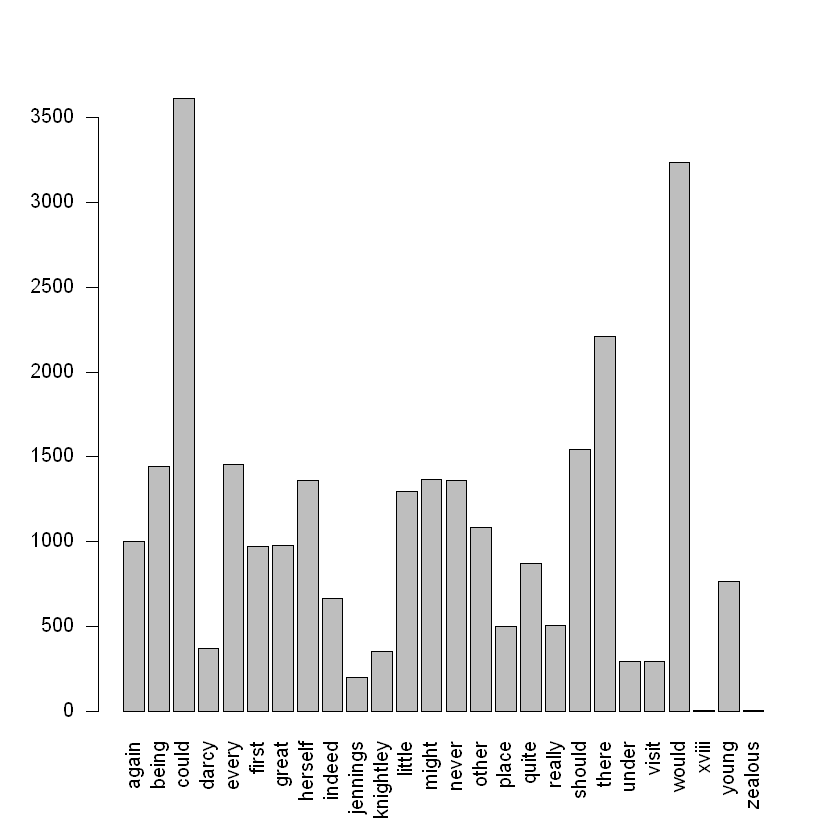

In [23]:
## install.packages("janeaustenr")
# install.packages("readr")
library(janeaustenr)
library(stringr)
library(readr)
library(tidyr)

extract_words <- function(book_name) {
    # extract the text of the book
    text <- subset(austen_books(), book == book_name)$text
    # extract words from the text and convert to lowercase
    str_extract_all(text, boundary("word")) %>% unlist %>% tolower
}

janeausten_words <- function() {
    # Names of the six books contained in janeaustenr
    books <- austen_books()$book %>% unique %>% as.character
    # Vector of words from all six books
    words <- sapply(books, extract_words) %>% unlist
    words
}
# Vector of words from all six books
words <- janeausten_words()


select_words <- function(letter, words, min_length = 1) {
    min_length_words <- words[nchar(words) >= min_length]
    grep(paste0("^", letter), min_length_words, value = TRUE)
}

max_frequency <- function(letter, words, min_length = 1) {
    w <- select_words(letter, words = words, min_length = min_length)
    frequency <- table(w)    
    frequency[which.max(frequency)]
}

# Most frequent "a"-word that is at least 5 chars long
word_max_fre = max_frequency(letter = "a", words = words, min_length = 1)
print(word_max_fre)

letters = c("a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p",
            "q","r","s", "t", "u", "v", "w", "x", "y", "z")

# Partitioning
result <- lapply(letters, max_frequency,
                 words = words, min_length = 5) %>% unlist()

result

# Barplot of result
barplot(result, las = 2)

### A simple embarrassingly parallel application
As a simple example of an embarrassingly parallel statistical application, we will repeatedly compute the mean of a set of normally distributed random numbers. For now, you will process it sequentially using a for loop, and the sapply() function.

In general, we recommend to implement any task that will be repeatedly applied to data as a function. Here, the function will be called mean_of_rnorm(). It generates random numbers with rnorm(), then computes their mean.

The objects n_numbers_per_replicate (set to 10000) and n_replicates (set to 50) have been created for you and determine the length of the random numbers vector and how many times the task is repeated, respectively.

[1] -0.1783054

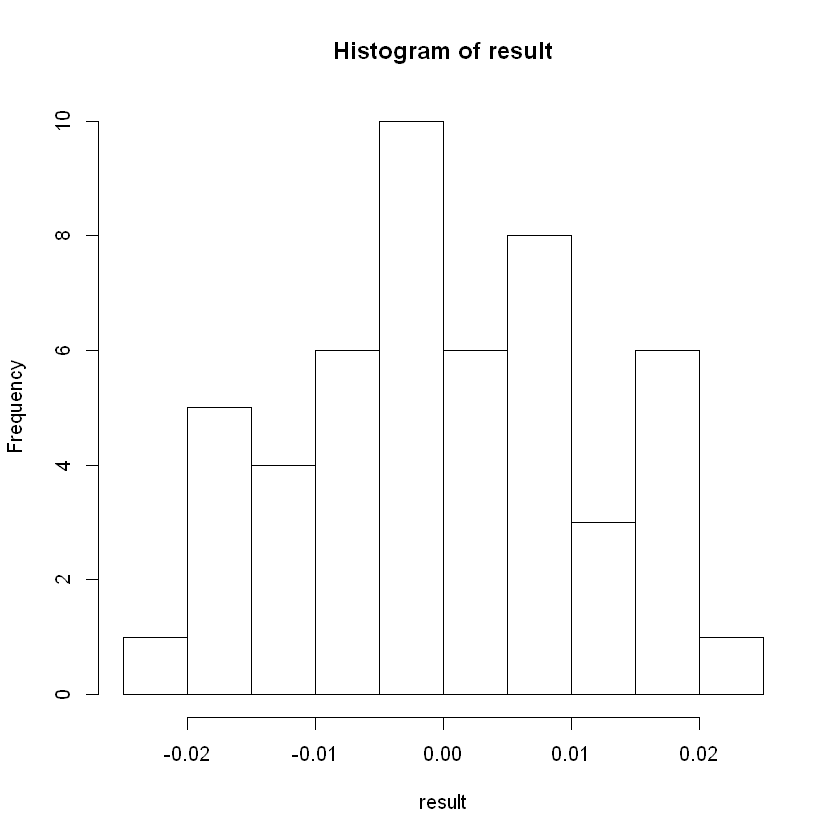

In [24]:
# Complete the function definition
mean_of_rnorm <- function(n) {
  # Generate normally distributed random numbers
  random_numbers <- rnorm(n)
  # Calculate the mean of the random numbers
  mean(random_numbers)
}

# Try it out
mean_of_rnorm(100)

n_replicates = 50
n_numbers_per_replicate = 10000

# Create a vector to store the results
result <- rep(NA, n_replicates)

# Set the random seed to 123
set.seed(123)

# Set up a for loop with iter from 1 to n_replicates
for (iter in 1:n_replicates) {
  # Call mean_of_rnorm with n_numbers_per_replicate
  result[iter] <- mean_of_rnorm(n_numbers_per_replicate)
}

# View the result
hist(result)

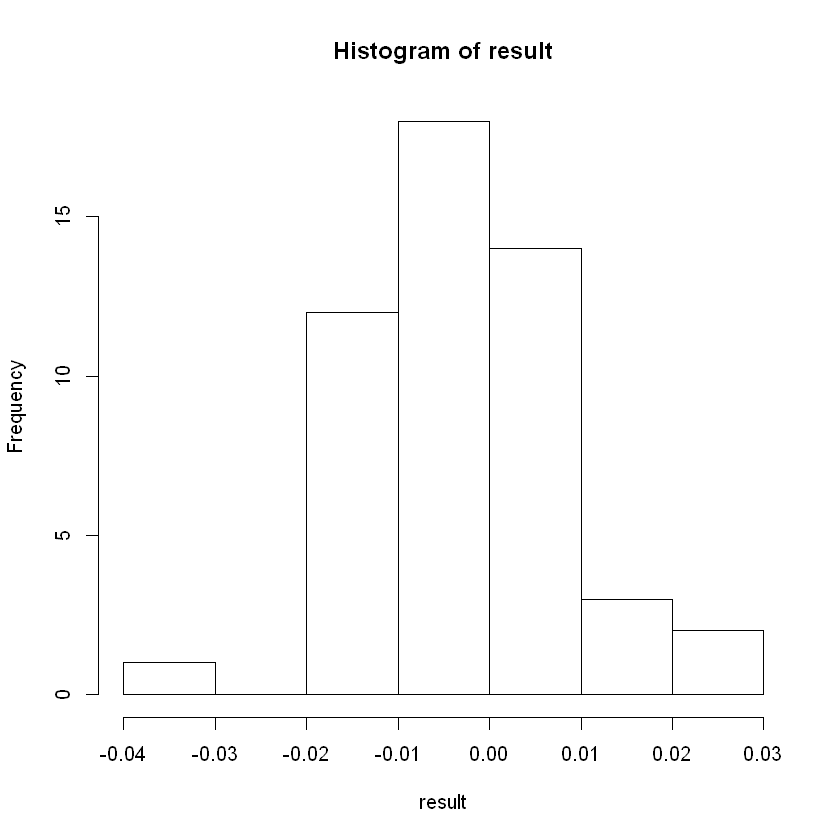

In [26]:
# Repeat n_numbers_per_replicate, n_replicates times
n <- rep(n_numbers_per_replicate, n_replicates)

# Call mean_of_rnorm() repeatedly using sapply()
result <- sapply(
  # The vectorized argument to pass
  n, 
  # The function to call
  mean_of_rnorm
)

# View the results
hist(result)

### Probabilistic projection of migration
Here, we'll continue the previous application. The 1000 sets of estimates in ar1est is a result of an estimation using migration data for the United States. The task is to project the future distribution of the US migration rate for 15 time points using the whole estimation dataset instead of just one row. You will generate a set of 10000 trajectories of length 15, each of which makes use of one parameter set, thus each parameter row is re-used 10 times. You will also visualize the results using a preloaded function show_migration().

Warning message:
"package 'ggplot2' was built under R version 3.6.3"

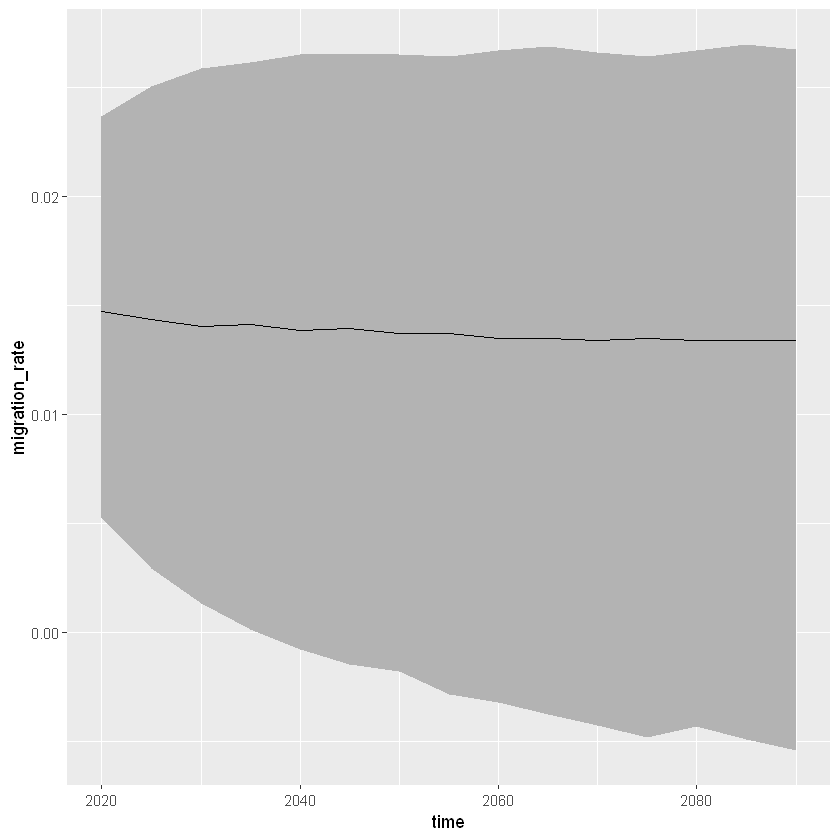

In [41]:
library(ggplot2)
ar1est = read.csv("US migration.csv", header = TRUE)

ar1_one_value <- function(est, r) {
    est['mu'] + est['phi'] * (r - est['mu']) + 
        rnorm(1, sd = est['sigma'])
}

ar1_one_trajectory <- function(est, rate0, len = 15) {
    trajectory <- rep(NA, len)
    rate <- rate0
    for (time in seq_len(len)) {
        trajectory[time] <- ar1_one_value(est, r = rate)
        rate <- trajectory[time]
    }
    trajectory
}

ar1_block_of_trajectories <- function(id, rate0 = 0.015, traj_len = 15, block_size = 10) {
    trajectories <- matrix(NA, nrow = block_size, ncol = traj_len)
    for (i in seq_len(block_size)) 
        trajectories[i,] <- ar1_one_trajectory(unlist(ar1est[id, ]), rate0 = rate0, len = traj_len)
    trajectories
}

# Function definition of ar1_multiple_blocks_of_trajectories()
ar1_multiple_blocks_of_trajectories <- function(ids, ...) {
  # Call ar1_block_of_trajectories() for each ids
  trajectories_by_block <- lapply(ids, ar1_block_of_trajectories, ...)
  
  # rbind results
  do.call(rbind,trajectories_by_block)
}

# Create a sequence from 1 to number of blocks
traj_ids <- seq_len(nrow(ar1est))

# Generate trajectories for all rows of the estimation dataset
trajs <- ar1_multiple_blocks_of_trajectories(
  ids = traj_ids, rate0 = 0.015,
  block_size = 10, traj_len = 15
)

show_migration <- function(trajs) {
    df <- data.frame(time = seq(2020, by = 5, len = ncol(trajs)),
                     migration_rate = apply(trajs, 2, median),
                     lower = apply(trajs, 2, quantile, 0.1),
                     upper = apply(trajs, 2, quantile, 0.9)
                    )
    g <- ggplot(df, aes(x = time, y = migration_rate)) + 
        geom_ribbon(aes(ymin = lower, ymax = upper), fill = "grey70") + 
        geom_line()
    print(g)
}

show_migration(trajs)

### Passing arguments via clusterApply()
We will use a similar example as in the last lesson where we evaluated rnorm() on a sequence c(4,3,2,1) in parallel, except this time you will pass additional arguments to rnorm(). These can be added to the clusterApply() function.

For comparison, you'll create a sequential solution using lapply() in Step 2 of this exercise and create a parallel solution in Step 3.

Even though computers have often more logical cores than physical cores, there is no speed advantage of running R processes on more than the number of physical cores.

In [46]:
# Load parallel

library(parallel)

# How many physical cores are available?
ncores <- detectCores(logical = FALSE)

# How many random numbers to generate
n = ncores:1

ncores <- detectCores(logical = FALSE)
n <- ncores:1

# Use lapply to call rnorm for each n,
# setting mean to 10 and sd to 2 
lapply(n, rnorm, mean = 10, sd = 2)

[[1]]
[1] 11.240759  9.477623  6.432061 14.460476  8.209092 11.405311

[[2]]
[1] 10.231272  8.265009 11.279988 13.251212  9.151702

[[3]]
[1]  8.938483  7.338232  9.654279 11.201527

[[4]]
[1]  8.293684 10.077658  7.108511

[[5]]
[1]  9.844828 10.589867

[[6]]
[1] 7.839076

In [47]:
# Create a cluster
cl <- makeCluster(ncores)

# Use clusterApply to call rnorm for each n in parallel,
# again setting mean to 10 and sd to 2 
clusterApply(cl, x = n, fun = rnorm,mean = 10, sd = 2)

# Stop the cluster
stopCluster(cl)

[[1]]
[1]  6.944702 10.446421 10.034611 10.648643 11.421659 10.858549

[[2]]
[1] 10.733949 10.611746  7.131131  8.745289 12.908606

[[3]]
[1] 10.973731 10.981461 13.487159  8.367116

[[4]]
[1]  8.679316 11.319433  9.097170

[[5]]
[1] 6.026314 8.118364

[[6]]
[1] 9.521898

### Sum in parallel
In the first lesson, you learned how to split sum(1:100) into independent pieces. For two cores, you can do sum(1:50) + sum(51:100). Here, we'll implement this using clusterApply(). The parallel package is preloaded, as well as a cluster object cl with two workers.

In [49]:
# Create a cluster
cl <- makeCluster(ncores)
# Evaluate partial sums in parallel
part_sums <- clusterApply(cl, x = c(1, 51),
                    fun = function(x) sum(x:(x + 49)))
# Total sum
total <- sum(unlist(part_sums))

# Check for correctness
total == sum(1:100)

[1] TRUE

### More tasks than workers
You will now parallelize your simple embarrassingly parallel application from a previous exercise. To repeatedly evaluate mean_of_rnorm() that computes the mean of a set of random numbers, a sequential for-loop solution looks as follows:

for(iter in seq_len(n_replicates)) 
    
    result[iter] <- mean_of_rnorm(n_numbers_per_replicate)
    

The iterations are independent of one another. Thus, we can convert it into a parallel form. Notice that we are now distributing many more tasks (namely n_replicates) than we have workers available.

The function mean_of_rnorm() is preloaded, as is the parallel library.

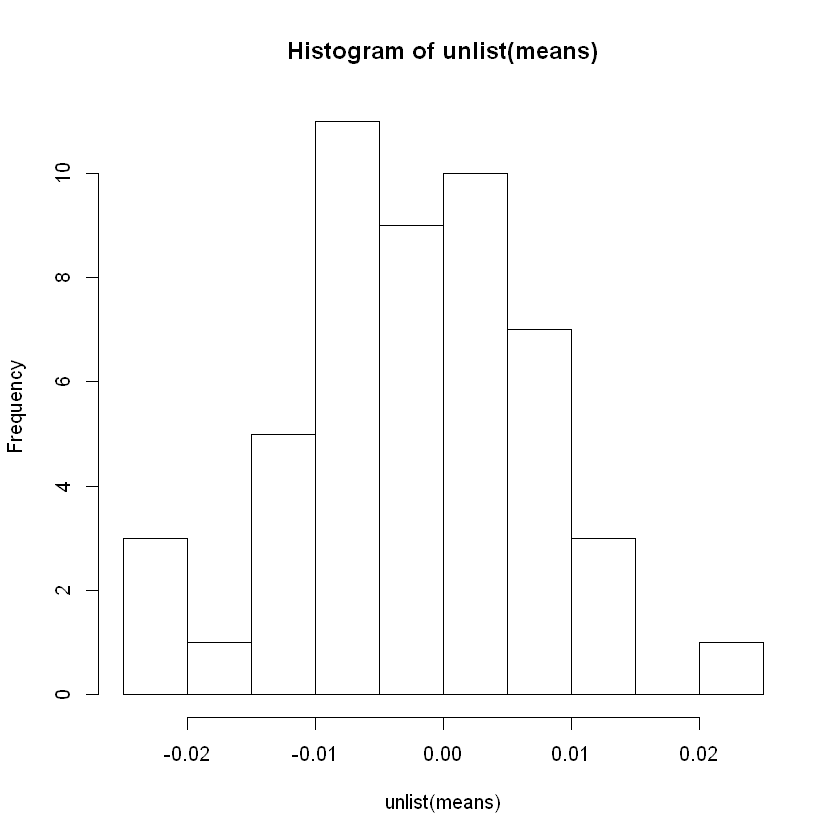

In [50]:
# Create a cluster and set parameters
cl <- makeCluster(2)
n_replicates <- 50
n_numbers_per_replicate <- 10000

# Parallel evaluation on n_numbers_per_replicate, n_replicates times
means <- clusterApply(cl, 
             x = rep(n_numbers_per_replicate, n_replicates), 
             fun = mean_of_rnorm)
                
# View results as histogram
hist(unlist(means))